# Example: Computing The Price of Zero Coupon United States Treasury Bills
Zero coupon United States Treasury Bills, sometimes called `T-bills` or just `Zeros`, are marketable fixed-income debt securities that pay an investor a defined amount, called the face or par value, at the bill’s termination.  The price of a zero-coupon Treasury bill $V_{B}$ with an effective (constant) interest rate of $\bar{r}$ and maturity of `T`-years at auction is the discounted face (par) value $V_{P}$ such that the net present value (NPV) of the bill is zero:

$$
\begin{equation}    
\text{NPV}(T,\bar{r}) = -V_{B} + \mathcal{D}_{T,0}^{-1}(\bar{r})\cdot{V_{P}} = 0
\end{equation}
$$

or equivalently:

$$
\begin{equation}
    V_{B}(T, \bar{r}) = \mathcal{D}_{T,0}^{-1}(\bar{r})\cdot{V_{P}}
\end{equation}
$$
    
The quantity `T` denotes the duration of the bill (in years),  $\bar{r}$ is the effective annualized interest rate, and $\mathcal{D}_{T,0}^{-1}(\bar{r})$ is the inverse of the multistep discount factor. Thus, a typical discrete discount factor takes the form:

$$
\mathcal{D}_{T,0}(\bar{r}) = \left(1+\frac{\bar{r}}{n}\right)^{n\cdot{T}}
$$

where $T$ is the bill’s duration, measured in units of `years` (assuming a `365-day` year), $n$ is the number of compounding events per year, and $\bar{r}$ denotes the annual effective interest rate earned by the `T-bill` (assumed to be constant, and assigned at the time of the `T-bill` auction). For T-bills, the interest is typically compounded twice a year; thus, $n = 2$.

## Learning objectives
This example will familiarize students with computing the price of zero coupon United States Treasury Bills, or `T-bills`. 

* __Prerequisite__: Before we begin any calculations, we'll load a United States Treasury action dataset for `T-bills.`
* __Objective 1__: First, we'll compute the price of `T-bills`, and validate our simulated prices using Treasury auction data from `2022` and `2023`. 
* __Objective 2__: Then, we'll show the price of treasury bills is inversely proportional to the interest rate of the `T-bill` by selecting a random `T-bill` from the dataset and simulating its auction price $V_{B}$ for different values of the effective annual interest, $\bar{r}$. Toward this, we will:
  * `Check`: First, we'll randomly select a `T-bill` and check that the nominal computed price is _similar_ to the observed auction price $V_{B}$ (we'll demonstrate the use of the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) and the [isapprox(...)](https://docs.julialang.org/en/v1/base/math/#Base.isapprox) function).
  * `TODO`: Then, we'll specify a range of $\bar{r}$-values to simulate using the [range function](https://docs.julialang.org/en/v1/base/math/#Base.range). 
  * `TODO`: Finally, we compute the `T-bill` price for different values of $\bar{r}$ and visualize the results by perturbing the nominal parameters of the randomly selected `T-bill.`
      * `Discussion question`: Is the slope of the interest rate versus the price line negative?
* __Project__: In the `project` associated with this module, we'll continue this exercise and explore how other factors influence the price of zero coupon Treasury bills.

## Setup
We load the [VLQuantitativeFinancePackage.jl](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl) package, and several other external [Julia](https://julialang.org/downloads/https://julialang.org/downloads/) packages, as well as some helper code included in the `src` directory, by calling the [include(...)](https://docs.julialang.org/en/v1/manual/code-loading/https://docs.julialang.org/en/v1/manual/code-loading/) command on the file `Include.jl`.

In [3]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-5660-CourseRepository-Fall-2024/lectures/week-2/L2a/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-CourseRepository-Fall-2024/lectures/week-2/L2a/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-5660-CourseRepository-Fall-2024/lectures/week-2/L2a`
  No Changes to `~/Desktop/julia_work/CHEME-5660-CourseRepository-Fall-2024/lectures/week-2/L2a/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-CourseRepository-Fall-2024/lectures/week-2/L2a/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-5660-CourseRepository-Fall-2024/lectures/week-2/L2a/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-CourseRepository-Fall-2

### Packages
In addition to [VLQuantitativeFinancePackage.jl](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl), the `Include.jl` file loads several external packages that we will use for our exercise:
* [DataFrames.jl](https://dataframes.juliadata.org/stable/) provides a set of tools for working with tabular data in [Julia](https://julialang.org). Its design and functionality are similar to those of [Pandas (in Python)](https://pandas.pydata.org) and [data.frame, data.table and dplyr (in R)](https://dplyr.tidyverse.org), making it a great general purpose data science tool.
* [Plots.jl](https://docs.juliaplots.org/stable/) is a plotting library in [Julia](https://julialang.org). We'll use this library for visualization

### Types
`Include.jl` loads some [problem-specific types](https://docs.julialang.org/en/v1/manual/functions/) that will be helpful for the analysis of T-bill pricing. 
* `MyUSTreasuryZeroCouponBondModel` is a [mutable type](https://docs.julialang.org/en/v1/manual/types/#Mutable-Composite-Types) holding the par value $V_{P}$, the duration $T$ and the interest rate $\bar{r}$ for a zero-coupon treasury bill.
    * You construct a `MyUSTreasuryZeroCouponBondModel` instance using the `build(...)` method, see example below.
* `DiscreteCompoundingModel` and `ContinuousCompoundingModel` are [immutable types](https://docs.julialang.org/en/v1/manual/types/#Composite-Types) that let our code know which compounding model we wish to use.
    * In this example, we'll primarily use discrete discounting 

### Functions
`Include.jl` loads the following [Julia functions](https://docs.julialang.org/en/v1/manual/functions/) into the notebook:

`MyTreasuryBillDataSet() -> DataFrame`
> The `MyTreasuryBillDataSet() -> DataFrame` loads a United States Treasury auction dataset, which we'll use in the example. The auction data is returned as a `DataFrame`, which is exported by the [DataFrames.jl package](https://dataframes.juliadata.org/stable/)

`build(model::Type{MyUSTreasuryZeroCouponBondModel}, data::NamedTuple) -> MyUSTreasuryZeroCouponBondModel`
> This function takes information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument (the par value, the number of compounding periods per year, the effective interest rate, and the duration of the T-bill) and returns an instance of the `MyUSTreasuryZeroCouponBondModel` custom type.

##  Prerequisite: Load the Treasury Auction Dataset
We'll explore `T-bill` prices from United States Treasury auctions between April 2023 and January 2024 downloaded as a `CSV` file using the [Auction query functionality of TreasuryDirect.gov](https://www.treasurydirect.gov/auctions/auction-query/). We load the `CSV` dataset using the `MyTreasuryBillDataSet()` function, which returns the auction data as a `DataFrame`:

In [8]:
dataset = MyTreasuryBillDataSet();

Finally, let's store the dimension of our auction dataset in the `number_of_bills` variable:

In [10]:
number_of_bills = nrow(dataset);

## Objective 1: Compute the Price of Zero-Coupon Treasury Bills at Auction
We begin the task of computing the `T-bill` price by building a discounting model. In this case, let's construct an instance of the `DiscreteCompoundingModel()` type and store this discount model in the `discount_model` variable:

In [12]:
discount_model = DiscreteCompoundingModel();

Next, let's build a zero-coupon Treasury bill model, an instance of the `MyUSTreasuryZeroCouponBondModel` type, using the `build(...)` method. The `build(...)` method requires two arguments: the `par` value of the `T-bill` and the `n` argument, i.e., the number of compounding periods per year. Store the zero-coupon model in the `model` variable:

In [14]:
model = build(MyUSTreasuryZeroCouponBondModel, (
    par = 100.0, n = 2
));

Finally, we compute the price of zero-coupon `T-bills` and compare the computed versus price versus the price observed at auction. We process each entry in the `dataset` using a `for-loop`. During each iteration of the loop:

* We get data from the `dataset` DataFrame and update the `T-bill` model instance. In particular, we set the observed price to the variable `VB`, we set the duration `T` field (which we convert to the number of years using the `securityterm` function) and the investment rate field, i.e., the annual interest rate on the `model` instance
* Next, we compute the price of the `T-bill` using the [Julia piping operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping) `|>` in compbination with the discounting model using short-cut syntax
* We then calculate the percentage error between the estimated and observed `T-bill` price, and store the simulation data for each iteration in the `computed_price_table` DataFrame using the `push!(...)` function

In [16]:
computed_price_table = DataFrame();
for i ∈ 1:number_of_bills
    
    VB = dataset[i, :Price];
    model.T = dataset[i, Symbol("Security Term")] |> String |> securityterm; # converts the duration in the data
    model.rate = dataset[i, Symbol("Investment Rate")];
        
    price_computed = model |> discount_model |> x-> x.price; # compute price assuming discrete discount
    absrtol = abs((VB - price_computed)/(price_computed)); # compute the abs of the relative tolerance 
    
    results_tuple = (
        CUSIP = dataset[i, :CUSIP],
        term = dataset[i, Symbol("Security Term")],
        rate = (dataset[i, Symbol("Investment Rate")] |> x-> 100*x),
        computed =  price_computed,
        actual = VB,
        rtol = absrtol
    );
    
    push!(computed_price_table, results_tuple)
end
computed_price_table

Row,CUSIP,term,rate,computed,actual,rtol
,String15,String7,Float64,Float64,Float64,Float64
1,912797GV3,4-Week,5.39,99.5928,99.5893,3.50655e-5
2,912797HD2,8-Week,5.423,99.1824,99.1771,5.35165e-5
3,912797HX8,17-Week,5.516,98.2416,98.2381,3.55206e-5
4,912797FA0,42-Day,5.412,99.3874,99.3828,4.60539e-5
5,912796ZD4,13-Week,5.503,98.6557,98.6502,5.58088e-5
6,912797GP6,26-Week,5.59,97.2883,97.2953,7.12772e-5
7,912797GU5,4-Week,5.395,99.5925,99.5889,3.52366e-5
8,912797HC4,8-Week,5.423,99.1824,99.1771,5.35165e-5
9,912797HW0,17-Week,5.5,98.2466,98.2431,3.5819e-5


## Objective 2: Compute the `T-bill` price versus the interest rate
Malkiel proposed five theorems that govern the price of fixed-income debt securities, e.g., Treasury Bills, Notes, and Bonds, as a function of the duration and yield values:

* [Malkiel, B. G. (1962). Expectations, Bond Prices, and the Term Structure of Interest Rates. The Quarterly Journal of Economics, 76(2), 197–218. https://doi.org/10.2307/1880816](https://www.jstor.org/stable/1880816https://www.jstor.org/stable/1880816)

The first of these theorems is that T-bill/note/bond prices are inversely proportional to the yield (the `investment rate` for `T-bills`):
> __Theorem 1__: Bond prices move inversely to bond yields.

In the paper, Malkiel proved Theorem 1 analytically. Let's test this relationship computationally. First, select a bill from the `dataset` by randomly selecting an index from `1...number_of_bills` using the built-in `rand(...)` function. We'll use this `T-bill` as our example to test `Theorem 1`:

In [18]:
random_bill_index = rand(1:number_of_bills)
println("Selected bill: $(random_bill_index)")

Selected bill: 50


In [19]:
dataset[random_bill_index,:] # what is the auction data for this bill?

Row,CUSIP,Security Type,Security Term,Auction Date,Issue Date,Maturity Date,Price,Investment Rate
,String15,String7,String7,String15,String15,String15,Float64,Float64
50,912797FA0,Bill,13-Week,07/10/2023,07/13/2023,10/12/2023,98.6729,0.05409


Create an instance of the `MyUSTreasuryZeroCouponBondModel` model from the randomly selected nominal auction data using the `build(...)` method, assuming a par value of `100 USD` with two compounding periods per year. These values will be passed as arguments to the `build(...)` method in the `par` and `n` parameters. Update the rest of the parameters on the `zero_coupon_model` instance from the `dataset.` The resulting zero-coupon model will be stored in the `model` variable:

In [21]:
zero_coupon_model = build(MyUSTreasuryZeroCouponBondModel, (
    par = 100.0, n = 2, 
    T = dataset[random_bill_index, Symbol("Security Term")] |> String |> securityterm,
    rate =  dataset[random_bill_index, Symbol("Investment Rate")]
)) |> discount_model;

#### Check: Is the computed price _similar_ to the auction price $V_{B}$?
The [isapprox function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox) checks the equality of numerical values up to some tolerance value, where either relative `rol` or absolute tolerance `atol` can be specified. Let's use relative tolerance. 
* If two values are within `rtol` of each other, the [isapprox function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox) returns `true`; otherwise, it returns `false`. When the [isapprox function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox) is combined with the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert), a `false` result generates an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError).

In [23]:
VB = dataset[random_bill_index, :Price];
computed_price = zero_coupon_model.price
@assert isapprox(VB, computed_price; rtol=1e-4)

### TODO: Specify a range of perturbation values
To simulate the impact of changes in the interest rate, let's perturb the effective nominal interest rate $\bar{r}$, with all other values held constant, i.e., generate a new rate of the form $\bar{r}\leftarrow\beta\cdot\bar{r}$, where $\beta$ is a perturbation value; if $\beta<1$ the perturbed interest rate is _less than_ the nominal rate, if $\beta=1$ the perturbed interest rate is _equals_ the nominal rate, and if $\beta>1$ the perturbed interest rate is _greater than_ the nominal rate.

* First, we specify the number of perturbation values we want to consider; we store this value in the `number_of_samples` variable. Note: if `number_of_samples` is odd, the perturbation range will include the nominal interest rate as the center value.
* Next, we specify the lower and upper values of the perturbation range; the lower bound is stored in the `β₁` variable, while the upper bound is stored in the `β₂` variable.
* Finally, we compute the perturbation array (stored in the `β`-variable) using the [range function](https://docs.julialang.org/en/v1/base/math/#Base.range) in combination with the [Julia pipe |> operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping), and the [collect function](https://docs.julialang.org/en/v1/base/collections/#Base.collect-Tuple{Type,%20Any}), which converts a range type to a collection, i.e., an array

In [25]:
number_of_samples = 7;
β₁ = 0.8;
β₂ = 1.2;
β = range(β₁, stop = β₂, length = number_of_samples) |> collect;

### TODO: Compute the change of the `T-bill` price as a function of the effective interest rate
Compute the price of the selected `T-bill` using different values for the effective interest rate and store the results in the `theorem_1_simulation_array` variable. Iterate through each value of the $\beta$ array using a `for` loop, where we use the [eachindex function](https://docs.julialang.org/en/v1/base/arrays/#Base.eachindex). For iteration $i$ of the loop:
* Get a value for the perturbation $\beta_{i}$ from the $\beta$-array, and compute the new effective interest rate $\bar{r}_{i} = \beta_{i}\cdot{\bar{r}}$.
* Update the `zero_coupon_model` instance with the new rate (set the `rate` field), and compute the new price
* Store the $\beta_{i}$ value in column 1 and the percentage difference in price in column 2 of the `theorem_1_simulation_array`
* Store the new value of the effective interest rate and the new price in columns 3 and 4, respectively. 

In [27]:
theorem_1_simulation_array = Array{Float64,2}(undef, number_of_samples, 4);
for i ∈ eachindex(β)
    
    β_value = β[i];
    r̄ = dataset[random_bill_index, Symbol("Investment Rate")];
    r̄_value = β_value*dataset[random_bill_index, Symbol("Investment Rate")];
    zero_coupon_model.rate = r̄_value;
    tmp = zero_coupon_model |> discount_model;
    new_price = tmp.price
    
    
    theorem_1_simulation_array[i,1] = β_value
    theorem_1_simulation_array[i,2] = ((new_price - computed_price)/(computed_price))*100
    theorem_1_simulation_array[i,3] = r̄_value
    theorem_1_simulation_array[i,4] = new_price
end
theorem_1_simulation_array;

### Visualize the perturbation $\beta$ versus the `%-change` in price

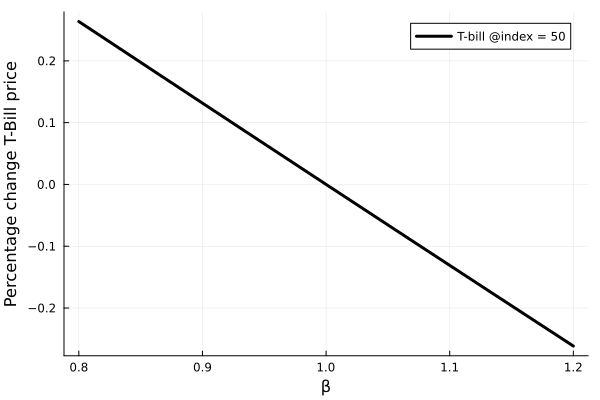

In [29]:
plot(theorem_1_simulation_array[:,1], theorem_1_simulation_array[:,2], lw=3, c=:black, xlabel="β", 
        ylabel="Percentage change T-Bill price", label="T-bill @index = $(random_bill_index)")

#### Discussion question: Is the slope of the interest rate versus the price line negative?
If the relationship between the price and the yield is inversely proportional, then the slope of price versus $\bar{r}$ should be negative; let's check this condition by computing the slope from the simulation array, store this in the `slope` variable:

In [31]:
slope = (theorem_1_simulation_array[end,4] - theorem_1_simulation_array[1,4])/(theorem_1_simulation_array[end,3] - theorem_1_simulation_array[1,3]);

Finally, use the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) to test of the slope is negative: if $\text{slope}>0$, i.e., `Theorem 1` is not supported, this test will throw an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError), otherwise the `Theorem 1` is supported by simulation:

In [33]:
@assert (slope < 0.0)

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.